In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.stats import mad_std

In [60]:
from glob import glob

# Open PDCSAP light curves
paths = glob('../TESSellate/downloads/*.npy')

Measure the typical standard deviation of the TESS TOI PDCSAP light curves

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


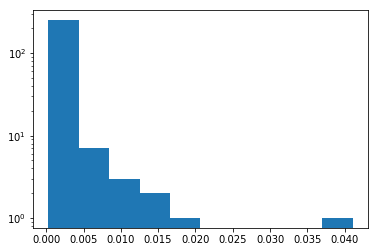

In [65]:
stdevs = []
for path in paths: 
    times, fluxes = np.load(path).T
    sort = np.argsort(times)
    times = times[sort]
    fluxes = fluxes[sort]
    
    split_times = []
    split_fluxes = []
    stdev = []
    diff_times = np.diff(times) > 2.5/60/24
    
    if np.count_nonzero(diff_times) > 0: 
        splits = np.concatenate([[0], np.argwhere(diff_times).T[0], [len(times)-1]])
        for i in range(1, len(splits)):
            t = times[splits[i-1]:splits[i]]
            f = fluxes[splits[i-1]:splits[i]] / np.nanmedian(fluxes[splits[i-1]:splits[i]])
            stdev.append(mad_std(f, ignore_nan=True))
            
    stdevs.append(np.nanmean(stdev))
    
stdevs = np.array(stdevs)
np.save('data/toi_stdevs.npy', stdevs)
plt.hist(stdevs, log=True);

In [68]:

half_max_paths = glob('data/half_solar_max/residuals_*')
max_paths = glob('data/solar_max/residuals_*')
more_max_paths = glob('data/1400/residuals_*')

half_max_residuals = []
for path in half_max_paths:     
    half_max_residuals.append(np.load(path))

max_residuals = []
for path in max_paths:     
    max_residuals.append(np.load(path))

more_max_residuals = []
for path in more_max_paths:     
    more_max_residuals.append(np.load(path))
    
half_max_residuals = np.concatenate(half_max_residuals)
max_residuals = np.concatenate(max_residuals)
more_max_residuals = np.concatenate(more_max_residuals)

(0, 0.0035)

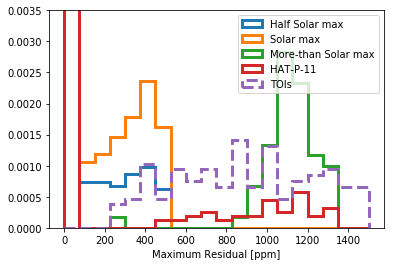

In [74]:
hat11 = np.load('data/hat11_residuals.npy')
histprops = dict(density=True, histtype='step', lw=3, range=[0, 1500])
plt.hist(half_max_residuals * 1e6, 20, label='Half Solar max', **histprops);
plt.hist(max_residuals * 1e6, 20, label='Solar max', **histprops);
plt.hist(more_max_residuals * 1e6, 20, label='More-than Solar max', **histprops);
plt.hist(hat11 * 1e6, 20, label='HAT-P-11', **histprops)

plt.hist(stdevs * 1e6, 20, label='TOIs', ls='--', **histprops)

plt.legend()
plt.xlabel('Maximum Residual [ppm]')
plt.ylim([0, 0.0035])

How often would the residual spot occultations be detectable given the noise distribution of TESS TOIs?

In [97]:
n_draws = 1000000

threshold_for_detection = 3
tess_noise_std = stdevs[np.random.randint(0, len(stdevs), size=n_draws)]

def randint(high, n_draws=n_draws):
    return np.random.randint(0, high, size=n_draws)

def fraction_detected(cond): 
    return np.count_nonzero(cond)/cond.shape[0]

half_max_detected = half_max_residuals[randint(len(half_max_residuals))] > threshold_for_detection * tess_noise_std
half_max_detected_fraction = fraction_detected(half_max_detected)

max_detected = max_residuals[randint(len(max_residuals))] > threshold_for_detection * tess_noise_std
max_detected_fraction = fraction_detected(max_detected)

more_max_detected = more_max_residuals[randint(len(more_max_residuals))] > threshold_for_detection * tess_noise_std
more_max_detected_fraction = fraction_detected(more_max_detected)

In [98]:
half_max_detected_fraction, max_detected_fraction, more_max_detected_fraction

(0.0, 0.0, 0.030277)

In [131]:
# 0.5 mmag -> flux [ppm]
half_mmag = (10**((0.5e-3) / 2.5) - 1) * 1e6
print(half_mmag)

460.6230728403382


Get cumulative Kepler [KOI list](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative)

In [100]:
from astropy.table import Table

koi_table = Table.read('data/cumulative_2019.07.05_01.52.59.votable')

In [241]:
shortlist = koi_table[(koi_table['koi_steff'] < 6000) & (koi_table['koi_depth'] > half_mmag) & (koi_table['koi_kepmag'] < 14.2)
                     & (koi_table['koi_disposition'] != b'FALSE POSITIVE')]

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [245]:
len(np.unique(shortlist['kepid']))

286

In [256]:
kepids, scatter_ratio = np.load('data/spot_searched.npy')

In [263]:
n_detected_kepler = (int(b'Kepler-17 b' in shortlist['kepler_name'].data.data) + 
                     int(b'Kepler-3 b' in shortlist['kepler_name'].data.data) + 
                     int(b'Kepler-63 b' in shortlist['kepler_name']))
n_searched_kepler = len(kepids)

fraction_kepler_observed = n_detected_kepler/n_searched_kepler

print(n_detected_kepler, n_searched_kepler, fraction_kepler_observed)

3 144 0.020833333333333332


$$ f_\text{observed} = f_\text{total} \cdot f_\text{detectable} $$
so
$$ f_\text{total} = f_\text{observed} \cdot  f_\text{detectable}^{-1}   $$

In [264]:
fraction_kepler_observed, more_max_detected_fraction

(0.020833333333333332, 0.030277)

In [265]:
f_total = fraction_kepler_observed / more_max_detected_fraction

print(f_total)

0.688091070229327


[Burgasser et al. 2013](http://adsabs.harvard.edu/abs/2003ApJ...586..512B): 
> When binary fractions (or other equivalent frequency statistics) are quoted in the literature, they are frequently assigned
Poisson uncertainties. However, the Poisson limit applies only in the case of a large sample, whereas the brown dwarf samples
discussed here are less than 30 in number. Hence, we derived statistical uncertainties by constructing a probability distribution
for $\epsilon_b$ given the total sample size, $N$, and the number of binaries in the sample, n. The binomial distribution determines the
probability of finding $n$ binaries given the sample size and binary fraction, as


$$B\left(n ; N, \epsilon_{b}\right)=\frac{N !}{n !(N-n) !} \epsilon_{b}^{n}\left(1-\epsilon_{b}\right)^{N-n}$$

In [266]:
n_searched_kepler * more_max_detected_fraction

4.359888

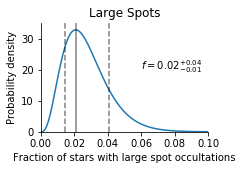

In [279]:
N = int(n_searched_kepler)# * more_max_detected_fraction)
# N = n_searched_kepler

n = n_detected_kepler

#eps = np.logspace(-5, -1.9, 1000)
eps = np.logspace(-5, 0, 1000)

B = np.math.factorial(N) / (np.math.factorial(n) * np.math.factorial(N - n)) * eps**n * (1 - eps)**(N-n)
integral = np.trapz(B, eps)

Bprime = B/integral

lower = 0.16
upper = 0.84

total_lower = 0
total_upper = 0

for i in range(1, len(eps)): 
    total_lower = np.trapz(Bprime[:i], eps[:i])
    if total_lower > lower:
        lower_bound = eps[i-1]
        break
        
for i in range(1, len(eps)): 
    total_upper = np.trapz(Bprime[:i], eps[:i])
    if total_upper > upper: 
        upper_bound = eps[i-1]
        break
    
plt.figure(figsize=(3, 2))
plt.plot(eps, Bprime)

c = eps[Bprime.argmax()]
plt.axvline(c, color='k', alpha=0.5)
for i in [lower_bound, upper_bound]: 
    plt.axvline(i, ls='--', color='k', alpha=0.5)

# print(c, "+", upper_bound, "-", lower_bound)
plt.title('Large Spots')
plt.text(0.06, 20, '$f = {0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$'.format(c, upper_bound, lower_bound))
plt.xlabel('Fraction of stars with large spot occultations')
plt.ylabel('Probability density')
plt.ylim([0, 35])
plt.xlim([0, 0.1]) #eps.max()])
ax = plt.gca()

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

plt.savefig('plots/fraction_spotted.pdf', bbox_inches='tight')